In [1]:
import cyecca.lie as lie
import casadi as ca
from cyecca.graph import draw_casadi
import numpy as np
import matplotlib.pyplot as plt
from cyecca.symbolic import casadi_to_sympy

w = ca.SX.sym("w", 3)  # process noise
v = ca.SX.sym("v", 3)  # measurement noise
x = lie.so3.elem(ca.SX.sym("x", 3))  # state
zh = ca.vertcat(0, 0, 1)  # z unit vector


omega = lie.so3.elem(ca.SX.sym("omega", 3))  # angular velocity
qr = lie.SO3Quat.elem(ca.SX.sym("qr", 4))
qe = x.exp(lie.SO3Quat)

A = -omega.ad()
J_r_inv = lie.so3.right_jacobian_inv(x)

x_dot = A @ x.param + J_r_inv @ w

# parameterize measurements in exponential coordinates
y_accel = (qe * qr).inverse() @ zh + v

f_g = ca.Function("g", [x.param, qr.param, v], [y_accel])
H = ca.jacobian(y_accel, x.param)
f_H = ca.Function("H", [x.param, qr.param], [H])

N = ca.jacobian(y_accel, v)

# test
euler0 = lie.SO3EulerB321.elem(ca.vertcat(0.1, 0, 0))
q0 = lie.SO3Quat.from_Euler(euler0)
f_H([0, 0, 0], q0.param)


f_J_r_inv = ca.Function("Jr_inv", [x.param], [J_r_inv])
f_J_r_inv([0, 0, 0])

DM(
[[1, 0, 0], 
 [0, 1, 0], 
 [0, 0, 1]])

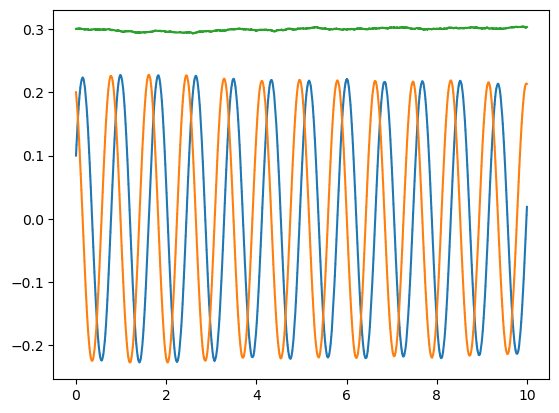

In [2]:
def simulate():
    tf = 10
    dt_control = 1.0 / 250
    dt_noise = 0.001
    dae = {"x": x.param, "p": omega.param, "u": w, "ode": x_dot}
    t_step = np.arange(0, dt_control, dt_noise)
    f_int = ca.integrator("F", "idas", dae, 0, t_step, {})

    t = np.arange(0, tf, dt_control)
    data = {
        "x": [],
        "t": [],
    }

    xi = [0.1, 0.2, 0.3]

    for ti in t:
        res = f_int(x0=xi, p=[0, 0, 10], u=0.1 * np.random.randn(3, len(t_step)))
        data["t"].append(ti + t_step)
        data["x"].append(res["xf"])
        xi = res["xf"][:, -1]
    data["x"] = np.hstack(data["x"])
    data["t"] = np.hstack(data["t"])
    return data


data = simulate()
plt.plot(data["t"], data["x"].T);